<a href="https://www.kaggle.com/code/someshyguy/chess-predictor?scriptVersionId=233322134" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 50.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147776 sha256=5eadabafcc49f63dbe11027d42d3d1afe8f63c0067adffa0e09a201596a2cef8
  Stored in directory: /root/.cache/pip/wheels/fb/5d/5c/59a62d8a695285e59ec9c1f66add6f8a9ac4152499a2be0113
Successfully built chess


In [2]:
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import chess

# Load the dataset
dataset_path = "/kaggle/input/chess-dataset/lichess_processed_1000000_games_first_15_moves.pkl"
with open(dataset_path, 'rb') as f:
    data = pickle.load(f)

print(f"Dataset size: {len(data)} games")

# 1. Get all unique ECO codes from the dataset
eco_codes = set()  # Use a set to automatically handle duplicates

# Extract ECO codes from the dataset
for game in data:
    eco_codes.add(game['eco'])

# 2. Create a mapping from ECO codes to integers
eco_encoding = {eco: idx for idx, eco in enumerate(sorted(eco_codes), start=1)}

# Optional: Add a default value for unknown ECO codes (this part remains the same)
default_eco = -1  # Default value for unknown ECO codes

# Process a single game into a tensor format for CNN
def convert_game_to_tensor(game_data):
    """
    Convert a single game into a tensor format suitable for CNN processing.
    
    Returns:
    - feature_vector: tabular features
    - board_tensor: board representation tensor
    """
    # 1. Extract tabular features
    feature_vector = []
    
    # Material and positional features at move 15
    feature_vector.append(game_data['white_material'])
    feature_vector.append(game_data['black_material'])
    feature_vector.append(game_data['material_balance'])
    feature_vector.append(int(game_data['white_can_castle']))
    feature_vector.append(int(game_data['black_can_castle']))
    feature_vector.append(game_data['white_center_control'])
    feature_vector.append(game_data['black_center_control'])
    
    # Legal moves count
    legal_moves = game_data['legal_moves_count'][:15]
    legal_moves = legal_moves + [0] * (15 - len(legal_moves))
    feature_vector.extend(legal_moves)
    
    # 2. Add ECO code to feature vector (integer encoding)
    eco_code = eco_encoding.get(game_data['eco'], default_eco)
    feature_vector.append(eco_code)
    
    # 3. Process actual moves (encoding the moves)
    # Creating a simple mapping for the moves
    move_encoding = {}  # Create or load a mapping for moves (you can use a one-hot encoding scheme or index-based encoding)
    move_index = []
    
    for move in game_data['moves'][:15]:  # Consider only the first 15 moves
        if move not in move_encoding:
            move_encoding[move] = len(move_encoding)  # Assign an index if not already present
        move_index.append(move_encoding[move])
    
    # Pad if there are fewer than 15 moves
    move_index = move_index + [0] * (15 - len(move_index))
    feature_vector.extend(move_index)
    
    # 4. Create a simple board representation
    # Instead of trying to recreate full board states, we'll use a simplified representation
    board_sequence = []
    
    # Get the lengths we need
    num_moves = min(15, len(game_data['legal_moves_count']) // 2)
    
    for i in range(num_moves):
        # Feature vector for this position
        position_features = []
        
        # Material and position features from the current state
        progress_ratio = (i + 1) / 15
        
        start_material = 39  # 8 pawns + 2 knights + 2 bishops + 2 rooks + 1 queen = 39
        white_material = int(start_material * (1 - progress_ratio) + game_data['white_material'] * progress_ratio)
        black_material = int(start_material * (1 - progress_ratio) + game_data['black_material'] * progress_ratio)
        material_balance = white_material - black_material
        
        position_features.append(white_material)
        position_features.append(black_material)
        position_features.append(material_balance)
        
        # Legal moves at this position (if available)
        move_idx = i * 2  # Each full move is 2 half-moves
        if move_idx < len(game_data['legal_moves_count']):
            position_features.append(game_data['legal_moves_count'][move_idx])
        else:
            position_features.append(0)
            
        if move_idx + 1 < len(game_data['legal_moves_count']):
            position_features.append(game_data['legal_moves_count'][move_idx + 1])
        else:
            position_features.append(0)
        
        # Add position index as a feature
        position_features.append(i)
        
        board_sequence.append(position_features)
    
    # Pad if we have fewer than 15 positions
    while len(board_sequence) < 15:
        # Padding with zeros
        board_sequence.append([0] * len(board_sequence[0]) if board_sequence else [0] * 6)
    
    return np.array(feature_vector, dtype=np.float32), np.array(board_sequence, dtype=np.float32)

# Custom dataset class
class ChessSequenceDataset(Dataset):
    def __init__(self, games_data, result_map=None):
        self.games_data = games_data
        self.result_map = result_map or {'1-0': 0, '0-1': 1, '1/2-1/2': 2}
        
        # Process all games at initialization
        self.features = []
        self.sequences = []
        self.labels = []
        
        for game in tqdm(games_data, desc="Processing games"):
            try:
                # Convert game to tensor format
                feature_vector, board_sequence = convert_game_to_tensor(game)
                
                self.features.append(feature_vector)
                self.sequences.append(board_sequence)
                self.labels.append(game['result_class'])
            except Exception as e:
                print(f"Error processing game: {e}")
                continue
        
        # Convert to numpy arrays
        self.features = np.array(self.features, dtype=np.float32)
        self.sequences = np.array(self.sequences, dtype=np.float32)
        self.labels = np.array(self.labels, dtype=np.int64)
        
        print(f"Processed {len(self.labels)} games")
        print(f"Features shape: {self.features.shape}")
        print(f"Sequences shape: {self.sequences.shape}")
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.sequences[idx], self.labels[idx]


# Create the dataset
print("Creating dataset...")
dataset = ChessSequenceDataset(data)

# Split into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Dataset size: 976124 games
Creating dataset...


Processing games: 100%|██████████| 976124/976124 [00:31<00:00, 31482.46it/s]


Processed 976124 games
Features shape: (976124, 38)
Sequences shape: (976124, 15, 6)


Using device: cuda
Starting training...


Epoch 1/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 225.65it/s]


Epoch 1/50, Loss: 1.0616, Accuracy: 0.4487
  Class 0 accuracy: 0.5432 (52749/97110)
  Class 1 accuracy: 0.3547 (32104/90501)
  Class 2 accuracy: 0.3607 (2746/7614)
  New best accuracy: 0.4487 - Model saved


Epoch 2/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 226.45it/s]


Epoch 2/50, Loss: 1.0562, Accuracy: 0.4572
  Class 0 accuracy: 0.4557 (44255/97110)
  Class 1 accuracy: 0.4674 (42299/90501)
  Class 2 accuracy: 0.3561 (2711/7614)
  New best accuracy: 0.4572 - Model saved


Epoch 3/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 225.61it/s]


Epoch 3/50, Loss: 1.0557, Accuracy: 0.4740
  Class 0 accuracy: 0.2719 (26406/97110)
  Class 1 accuracy: 0.7067 (63961/90501)
  Class 2 accuracy: 0.2850 (2170/7614)
  New best accuracy: 0.4740 - Model saved


Epoch 4/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 229.90it/s]


Epoch 4/50, Loss: 1.0554, Accuracy: 0.4552
  Class 0 accuracy: 0.6434 (62479/97110)
  Class 1 accuracy: 0.2628 (23787/90501)
  Class 2 accuracy: 0.3406 (2593/7614)


Epoch 5/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 226.06it/s]


Epoch 5/50, Loss: 1.0549, Accuracy: 0.4837
  Class 0 accuracy: 0.4602 (44692/97110)
  Class 1 accuracy: 0.5245 (47468/90501)
  Class 2 accuracy: 0.2971 (2262/7614)
  New best accuracy: 0.4837 - Model saved


Epoch 6/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 229.71it/s]


Epoch 6/50, Loss: 1.0546, Accuracy: 0.4424
  Class 0 accuracy: 0.4361 (42350/97110)
  Class 1 accuracy: 0.4537 (41061/90501)
  Class 2 accuracy: 0.3882 (2956/7614)


Epoch 7/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 228.35it/s]


Epoch 7/50, Loss: 1.0546, Accuracy: 0.4641
  Class 0 accuracy: 0.2870 (27874/97110)
  Class 1 accuracy: 0.6663 (60299/90501)
  Class 2 accuracy: 0.3188 (2427/7614)


Epoch 8/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 221.70it/s]


Epoch 8/50, Loss: 1.0546, Accuracy: 0.4908
  Class 0 accuracy: 0.3875 (37630/97110)
  Class 1 accuracy: 0.6199 (56104/90501)
  Class 2 accuracy: 0.2724 (2074/7614)
  New best accuracy: 0.4908 - Model saved


Epoch 9/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 223.81it/s]


Epoch 9/50, Loss: 1.0546, Accuracy: 0.4531
  Class 0 accuracy: 0.3723 (36153/97110)
  Class 1 accuracy: 0.5474 (49542/90501)
  Class 2 accuracy: 0.3637 (2769/7614)


Epoch 10/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 227.42it/s]


Epoch 10/50, Loss: 1.0545, Accuracy: 0.4655
  Class 0 accuracy: 0.2700 (26220/97110)
  Class 1 accuracy: 0.6880 (62265/90501)
  Class 2 accuracy: 0.3131 (2384/7614)


Epoch 11/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 224.05it/s]


Epoch 11/50, Loss: 1.0546, Accuracy: 0.4716
  Class 0 accuracy: 0.4730 (45929/97110)
  Class 1 accuracy: 0.4827 (43684/90501)
  Class 2 accuracy: 0.3216 (2449/7614)


Epoch 12/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 227.80it/s]


Epoch 12/50, Loss: 1.0541, Accuracy: 0.4569
  Class 0 accuracy: 0.2637 (25609/97110)
  Class 1 accuracy: 0.6751 (61097/90501)
  Class 2 accuracy: 0.3269 (2489/7614)


Epoch 13/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 227.47it/s]


Epoch 13/50, Loss: 1.0540, Accuracy: 0.5000
  Class 0 accuracy: 0.5667 (55028/97110)
  Class 1 accuracy: 0.4491 (40645/90501)
  Class 2 accuracy: 0.2560 (1949/7614)
  New best accuracy: 0.5000 - Model saved


Epoch 14/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 229.18it/s]


Epoch 14/50, Loss: 1.0541, Accuracy: 0.4975
  Class 0 accuracy: 0.5731 (55649/97110)
  Class 1 accuracy: 0.4362 (39480/90501)
  Class 2 accuracy: 0.2624 (1998/7614)


Epoch 15/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 227.97it/s]


Epoch 15/50, Loss: 1.0539, Accuracy: 0.4631
  Class 0 accuracy: 0.3127 (30363/97110)
  Class 1 accuracy: 0.6354 (57506/90501)
  Class 2 accuracy: 0.3329 (2535/7614)


Epoch 16/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 225.72it/s]


Epoch 16/50, Loss: 1.0538, Accuracy: 0.5157
  Class 0 accuracy: 0.6140 (59628/97110)
  Class 1 accuracy: 0.4364 (39496/90501)
  Class 2 accuracy: 0.2051 (1562/7614)
  New best accuracy: 0.5157 - Model saved


Epoch 17/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 227.87it/s]


Epoch 17/50, Loss: 1.0540, Accuracy: 0.5055
  Class 0 accuracy: 0.4351 (42254/97110)
  Class 1 accuracy: 0.6041 (54671/90501)
  Class 2 accuracy: 0.2315 (1763/7614)


Epoch 18/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 227.52it/s]


Epoch 18/50, Loss: 1.0538, Accuracy: 0.5024
  Class 0 accuracy: 0.3754 (36451/97110)
  Class 1 accuracy: 0.6619 (59901/90501)
  Class 2 accuracy: 0.2272 (1730/7614)


Epoch 19/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 224.03it/s]


Epoch 19/50, Loss: 1.0538, Accuracy: 0.4682
  Class 0 accuracy: 0.3809 (36989/97110)
  Class 1 accuracy: 0.5731 (51863/90501)
  Class 2 accuracy: 0.3345 (2547/7614)


Epoch 20/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 227.55it/s]


Epoch 20/50, Loss: 1.0540, Accuracy: 0.4532
  Class 0 accuracy: 0.4419 (42910/97110)
  Class 1 accuracy: 0.4721 (42728/90501)
  Class 2 accuracy: 0.3725 (2836/7614)


Epoch 21/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 224.69it/s]


Epoch 21/50, Loss: 1.0542, Accuracy: 0.4958
  Class 0 accuracy: 0.4685 (45500/97110)
  Class 1 accuracy: 0.5451 (49332/90501)
  Class 2 accuracy: 0.2585 (1968/7614)


Epoch 22/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 223.99it/s]


Epoch 22/50, Loss: 1.0537, Accuracy: 0.4832
  Class 0 accuracy: 0.2060 (20009/97110)
  Class 1 accuracy: 0.8034 (72706/90501)
  Class 2 accuracy: 0.2115 (1610/7614)


Epoch 23/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 224.24it/s]


Epoch 23/50, Loss: 1.0539, Accuracy: 0.4927
  Class 0 accuracy: 0.4090 (39718/97110)
  Class 1 accuracy: 0.6023 (54511/90501)
  Class 2 accuracy: 0.2585 (1968/7614)


Epoch 24/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 221.25it/s]


Epoch 24/50, Loss: 1.0544, Accuracy: 0.4846
  Class 0 accuracy: 0.5533 (53731/97110)
  Class 1 accuracy: 0.4268 (38625/90501)
  Class 2 accuracy: 0.2964 (2257/7614)


Epoch 25/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 225.90it/s]


Epoch 25/50, Loss: 1.0540, Accuracy: 0.4656
  Class 0 accuracy: 0.5229 (50778/97110)
  Class 1 accuracy: 0.4141 (37475/90501)
  Class 2 accuracy: 0.3469 (2641/7614)


Epoch 26/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 224.82it/s]


Epoch 26/50, Loss: 1.0542, Accuracy: 0.4499
  Class 0 accuracy: 0.3531 (34291/97110)
  Class 1 accuracy: 0.5604 (50717/90501)
  Class 2 accuracy: 0.3716 (2829/7614)


Epoch 27/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 226.80it/s]


Epoch 27/50, Loss: 1.0539, Accuracy: 0.4770
  Class 0 accuracy: 0.5179 (50293/97110)
  Class 1 accuracy: 0.4469 (40441/90501)
  Class 2 accuracy: 0.3139 (2390/7614)


Epoch 28/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 226.09it/s]


Epoch 28/50, Loss: 1.0538, Accuracy: 0.4787
  Class 0 accuracy: 0.5468 (53095/97110)
  Class 1 accuracy: 0.4205 (38053/90501)
  Class 2 accuracy: 0.3021 (2300/7614)


Epoch 29/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 227.73it/s]


Epoch 29/50, Loss: 1.0545, Accuracy: 0.4752
  Class 0 accuracy: 0.4348 (42228/97110)
  Class 1 accuracy: 0.5316 (48112/90501)
  Class 2 accuracy: 0.3184 (2424/7614)


Epoch 30/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 228.44it/s]


Epoch 30/50, Loss: 1.0537, Accuracy: 0.4718
  Class 0 accuracy: 0.4326 (42014/97110)
  Class 1 accuracy: 0.5264 (47640/90501)
  Class 2 accuracy: 0.3230 (2459/7614)


Epoch 31/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 227.84it/s]


Epoch 31/50, Loss: 1.0542, Accuracy: 0.4566
  Class 0 accuracy: 0.3367 (32699/97110)
  Class 1 accuracy: 0.5935 (53710/90501)
  Class 2 accuracy: 0.3576 (2723/7614)


Epoch 32/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 226.12it/s]


Epoch 32/50, Loss: 1.0541, Accuracy: 0.4598
  Class 0 accuracy: 0.6331 (61482/97110)
  Class 1 accuracy: 0.2833 (25641/90501)
  Class 2 accuracy: 0.3459 (2634/7614)


Epoch 33/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 226.99it/s]


Epoch 33/50, Loss: 1.0543, Accuracy: 0.4658
  Class 0 accuracy: 0.5199 (50483/97110)
  Class 1 accuracy: 0.4182 (37849/90501)
  Class 2 accuracy: 0.3411 (2597/7614)


Epoch 34/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 229.74it/s]


Epoch 34/50, Loss: 1.0542, Accuracy: 0.4867
  Class 0 accuracy: 0.4402 (42751/97110)
  Class 1 accuracy: 0.5532 (50066/90501)
  Class 2 accuracy: 0.2899 (2207/7614)


Epoch 35/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 229.00it/s]


Epoch 35/50, Loss: 1.0541, Accuracy: 0.5062
  Class 0 accuracy: 0.6174 (59956/97110)
  Class 1 accuracy: 0.4099 (37097/90501)
  Class 2 accuracy: 0.2326 (1771/7614)


Epoch 36/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 228.60it/s]


Epoch 36/50, Loss: 1.0542, Accuracy: 0.4680
  Class 0 accuracy: 0.4072 (39544/97110)
  Class 1 accuracy: 0.5450 (49326/90501)
  Class 2 accuracy: 0.3266 (2487/7614)


Epoch 37/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 224.28it/s]


Epoch 37/50, Loss: 1.0541, Accuracy: 0.4587
  Class 0 accuracy: 0.4064 (39469/97110)
  Class 1 accuracy: 0.5236 (47383/90501)
  Class 2 accuracy: 0.3538 (2694/7614)


Epoch 38/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 228.23it/s]


Epoch 38/50, Loss: 1.0540, Accuracy: 0.4901
  Class 0 accuracy: 0.3989 (38742/97110)
  Class 1 accuracy: 0.6055 (54795/90501)
  Class 2 accuracy: 0.2803 (2134/7614)


Epoch 39/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 227.51it/s]


Epoch 39/50, Loss: 1.0538, Accuracy: 0.4861
  Class 0 accuracy: 0.2125 (20635/97110)
  Class 1 accuracy: 0.8035 (72714/90501)
  Class 2 accuracy: 0.2025 (1542/7614)


Epoch 40/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 227.73it/s]


Epoch 40/50, Loss: 1.0540, Accuracy: 0.4670
  Class 0 accuracy: 0.6095 (59188/97110)
  Class 1 accuracy: 0.3258 (29487/90501)
  Class 2 accuracy: 0.3289 (2504/7614)


Epoch 41/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 229.13it/s]


Epoch 41/50, Loss: 1.0542, Accuracy: 0.4249
  Class 0 accuracy: 0.2252 (21868/97110)
  Class 1 accuracy: 0.6411 (58021/90501)
  Class 2 accuracy: 0.4025 (3065/7614)


Epoch 42/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 227.60it/s]


Epoch 42/50, Loss: 1.0539, Accuracy: 0.3880
  Class 0 accuracy: 0.3632 (35271/97110)
  Class 1 accuracy: 0.4039 (36556/90501)
  Class 2 accuracy: 0.5138 (3912/7614)


Epoch 43/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 229.46it/s]


Epoch 43/50, Loss: 1.0537, Accuracy: 0.4571
  Class 0 accuracy: 0.2320 (22532/97110)
  Class 1 accuracy: 0.7106 (64309/90501)
  Class 2 accuracy: 0.3157 (2404/7614)


Epoch 44/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 226.53it/s]


Epoch 44/50, Loss: 1.0543, Accuracy: 0.4392
  Class 0 accuracy: 0.2233 (21689/97110)
  Class 1 accuracy: 0.6770 (61273/90501)
  Class 2 accuracy: 0.3641 (2772/7614)


Epoch 45/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 226.12it/s]


Epoch 45/50, Loss: 1.0537, Accuracy: 0.4461
  Class 0 accuracy: 0.5346 (51914/97110)
  Class 1 accuracy: 0.3561 (32226/90501)
  Class 2 accuracy: 0.3876 (2951/7614)


Epoch 46/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 226.79it/s]


Epoch 46/50, Loss: 1.0543, Accuracy: 0.4841
  Class 0 accuracy: 0.2594 (25188/97110)
  Class 1 accuracy: 0.7449 (67415/90501)
  Class 2 accuracy: 0.2509 (1910/7614)


Epoch 47/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 226.30it/s]


Epoch 47/50, Loss: 1.0539, Accuracy: 0.4374
  Class 0 accuracy: 0.3215 (31224/97110)
  Class 1 accuracy: 0.5650 (51130/90501)
  Class 2 accuracy: 0.3980 (3030/7614)


Epoch 48/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 226.34it/s]


Epoch 48/50, Loss: 1.0540, Accuracy: 0.4856
  Class 0 accuracy: 0.5249 (50970/97110)
  Class 1 accuracy: 0.4595 (41585/90501)
  Class 2 accuracy: 0.2946 (2243/7614)


Epoch 49/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 228.16it/s]


Epoch 49/50, Loss: 1.0540, Accuracy: 0.4737
  Class 0 accuracy: 0.3449 (33489/97110)
  Class 1 accuracy: 0.6259 (56644/90501)
  Class 2 accuracy: 0.3079 (2344/7614)


Epoch 50/50 Testing: 100%|██████████| 1526/1526 [00:06<00:00, 227.00it/s]


Epoch 50/50, Loss: 1.0540, Accuracy: 0.4692
  Class 0 accuracy: 0.2991 (29047/97110)
  Class 1 accuracy: 0.6647 (60156/90501)
  Class 2 accuracy: 0.3144 (2394/7614)
Performing detailed evaluation...


Evaluating: 100%|██████████| 1526/1526 [00:06<00:00, 240.33it/s]


Classification Report:
              precision    recall  f1-score   support

   White Win       0.68      0.30      0.42     97110
   Black Win       0.53      0.66      0.59     90501
        Draw       0.06      0.31      0.10      7614

    accuracy                           0.47    195225
   macro avg       0.42      0.43      0.37    195225
weighted avg       0.59      0.47      0.48    195225

Analysis complete!


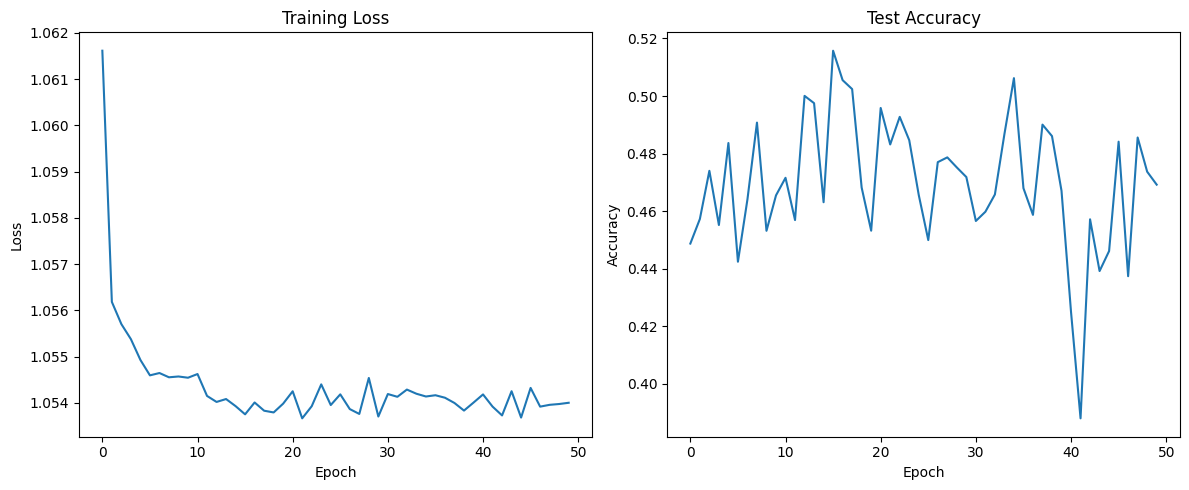

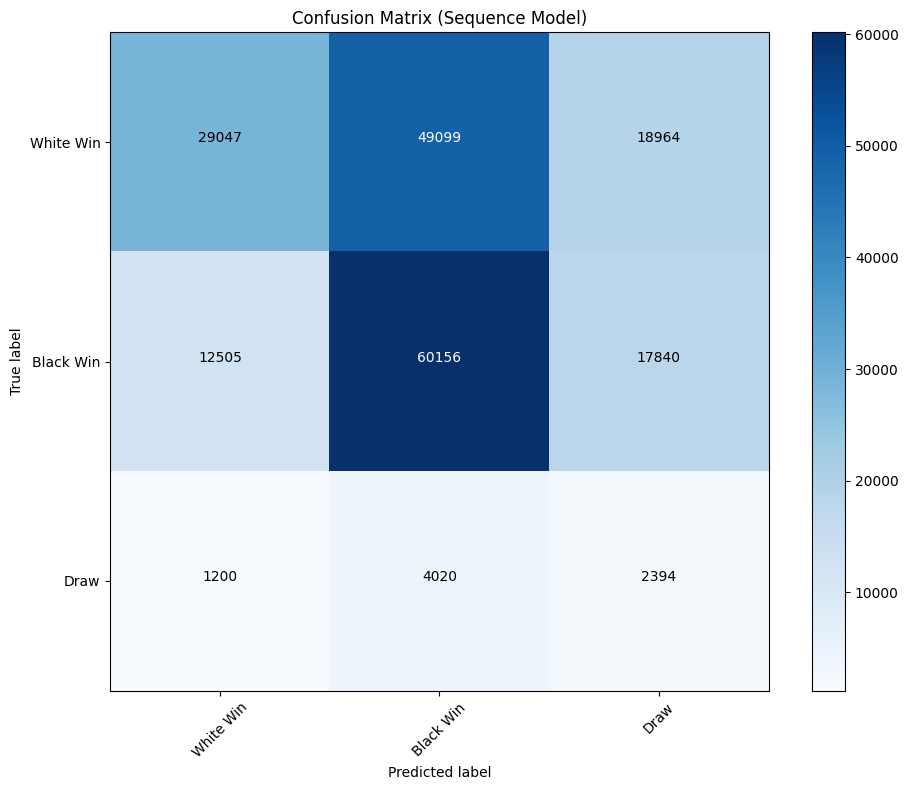

In [3]:
# Define the combined CNN-RNN model
class ChessSequenceModel(nn.Module):
    def __init__(self, tabular_size, seq_feature_size):
        super().__init__()
        
        # Add more dropout and batch normalization
        self.tabular_net = nn.Sequential(
            nn.Linear(tabular_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),  # Increased dropout
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3)  # Add an extra dropout layer
        )
        
        # Consider using bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=seq_feature_size,
            hidden_size=128,
            num_layers=2,  # Increase layers
            batch_first=True,
            bidirectional=True,  # Capture patterns in both directions
            dropout=0.3
        )
        
        # Adjust combined size for bidirectional LSTM
        combined_size = 64 + (128 * 2)  # Bidirectional doubles hidden size
        self.classifier = nn.Sequential(
            nn.Linear(combined_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 3)
        )
    
    def forward(self, tabular, sequence):
        tabular_features = self.tabular_net(tabular)
        
        # Handle bidirectional LSTM
        lstm_out, (h_n, c_n) = self.lstm(sequence)
        
        # Concatenate forward and backward last hidden states
        lstm_features = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        
        combined = torch.cat((tabular_features, lstm_features), dim=1)
        output = self.classifier(combined)
        
        return output

# Initialize model
tabular_size = dataset.features.shape[1]
seq_feature_size = dataset.sequences.shape[2]
model = ChessSequenceModel(tabular_size, seq_feature_size)

# Define training parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Calculate class weights
class_counts = np.bincount(dataset.labels)
class_weights = 1.0 / class_counts
class_weights = class_weights / np.sum(class_weights) * len(class_counts)
weights = torch.FloatTensor(class_weights).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-5)

# Move model to device
model.to(device)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    train_losses = []
    test_accuracies = []
    best_accuracy = 0.0
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for tabular, sequence, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} Training"):
            tabular, sequence, labels = tabular.to(device), sequence.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(tabular, sequence)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * tabular.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # Evaluation phase
        model.eval()
        correct = 0
        total = 0
        class_correct = [0, 0, 0]
        class_total = [0, 0, 0]
        
        with torch.no_grad():
            for tabular, sequence, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{epochs} Testing"):
                tabular, sequence, labels = tabular.to(device), sequence.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(tabular, sequence)
                _, predicted = torch.max(outputs.data, 1)
                
                # Calculate accuracy
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Per-class accuracy
                for i in range(3):
                    class_mask = (labels == i)
                    class_correct[i] += ((predicted == labels) & class_mask).sum().item()
                    class_total[i] += class_mask.sum().item()
        
        accuracy = correct / total
        test_accuracies.append(accuracy)
        
        # Print statistics
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")
        for i in range(3):
            class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
            print(f"  Class {i} accuracy: {class_acc:.4f} ({class_correct[i]}/{class_total[i]})")
        
        # Save the best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': accuracy,
            }, 'best_chess_sequence_model.pth')
            print(f"  New best accuracy: {best_accuracy:.4f} - Model saved")
    
    # Plot training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    plt.tight_layout()
    plt.savefig('sequence_training_curves.png')
    
    return model, train_losses, test_accuracies

# Train the model
print("Starting training...")
model, train_losses, test_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, epochs=50
)

# Evaluate the model
def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for tabular, sequence, labels in tqdm(test_loader, desc="Evaluating"):
            tabular, sequence, labels = tabular.to(device), sequence.to(device), labels.to(device)
            outputs = model(tabular, sequence)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Create confusion matrix
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Sequence Model)')
    plt.colorbar()
    
    classes = ['White Win', 'Black Win', 'Draw']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('sequence_confusion_matrix.png')
    
    # Print classification report
    report = classification_report(all_labels, all_preds, target_names=classes)
    print("Classification Report:")
    print(report)
    
    return cm, report

# Run evaluation
print("Performing detailed evaluation...")
cm, report = evaluate_model(model, test_loader)

print("Analysis complete!")